# **The HSIC Bottleneck: Deep Learning Without Backpropagation**

I attempted to simulate the proposed method outlined in [[1]](https://arxiv.org/abs/1908.01580), where information bottleneck (IB) is employed as the loss function for training the network. Utilizing IB as the loss function offers several advantages in comparison with the conventional cross-entropy or similar loss functions, which necessitate error backpropagation (EBP) for network training. 


**Information Bottleneck**\
It is noteworthy to investigate more about IB as a cost function in training deep neural networks (DNNs) to gain a better understanding of its benefits for deep learning (DL).\
The main formula of IB as the loss function is [[2]](https://arxiv.org/abs/1503.02406)

$$\min_\theta L(\theta) = \min_{\theta} I(X,Z(\theta))-\beta I(Y,Z(\theta))$$
Here, $I(X,Z(\theta))$ refers to the mutual information between the input ($X$) and output ($Z(\theta)$) of the network with parameters of $\theta$. Labels of the data are also shown by $Y$.
Mutual information between two random variables is linked to the joint and single entropy of each variable, as demonstrated below

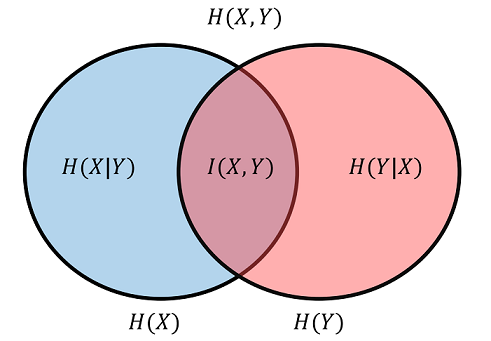

By employing the IB loss function and learning the weights $\theta$ to minimize IB, the resulting mapping offered by the network, $Z(\theta)$, can be shown as

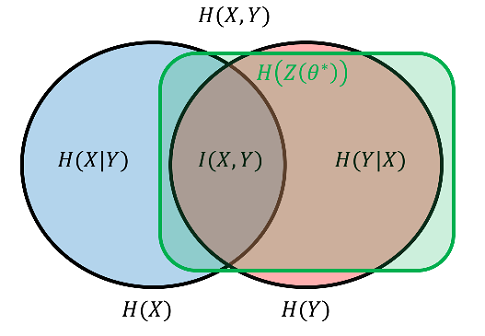

Through the learning process, the optimum set of weights are determined to maintain a balance between increasing $I(Y,Z(\theta))$ (intersection of green and red shapes) and decreasing $I(X,Z(\theta))$ (intersection of green and blue shapes).\
The IB loss function is designed to facilitate the network's compression of information in $X$ (encoding process) by decreasing the first term, $I(X,Z(\theta))$. Additionally, the network should increase $I(Y,Z(\theta))$ to capture all the information required for decoding [[3]](https://arxiv.org/abs/1703.00810).

**Forward Layer-by-Layer Updating Rule**\
The authors of [1] propose a method based on IB loss to update the weights of each layer without EBP. In this method, during the learning process, each layer receives an input and maps it to an output. For the output of each layer, $Z_i(\theta_i)$, IB can be calculated, and with a simple stochastic gradient descent (SGD), the weights of each layer, $\theta_i$, can be updated ($i$ shows the index of the layer).
This approach involves updating the weights in the forward flow using IB for the output of each layer, thus eliminating the need for EBP and backward propagation. This method provides the following benefits:


*  The update locking problem is solved since IB can be computed based on the output of each layer, and there is no need for waiting to find the output of the entire network, which was required for computing the loss function and backpropagating the error.
*   This method addresses the gradient vanishing and exploding problem commonly encountered in deep learning, since the amount of gradients through the chain law and EBP can become smaller or larger, leading to slow learning or instability. By removing EBP, this problem is mitigated.
*   The previous benefit introduces the method as an alternative to skip connection methods.
*   The authors claimed that the method also solves the overfitting problem due to its design and the properties of its IB-based loss function.






# **Importing Required Packages and Libraries**

Here, we import the required libraries and packages.

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.datasets import mnist
from matplotlib import pyplot as plt
import numpy as np
import random

# **Dataset Preparation: MNIST**

The MNIST dataset is loaded. Also, it is normalized and flattened for the dense network. Labels are transformed to one-hot format.

shape of train input: (60000, 784) shape of train label: (60000, 10) 
shape of test input (10000, 784) shape of test label: (10000, 784)


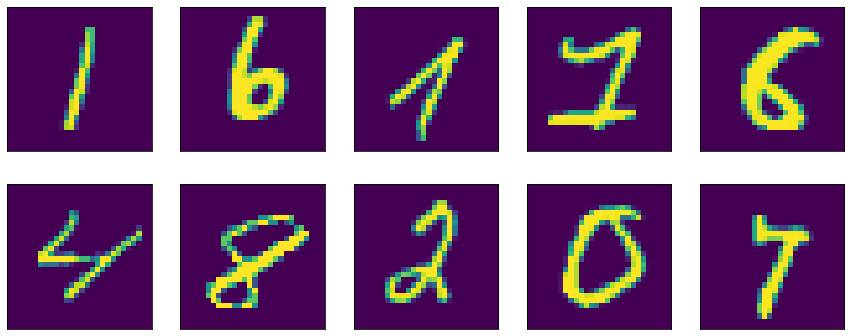

In [64]:
# load dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
num_class = 10;

# sort dataset based on classes
idx = np.argsort(y_train)
y_train_sorted = y_train[idx]

idxt = np.argsort(y_test)
y_test_sorted = y_test[idxt]

# flatten and convert from integers to floats
image_vector_size = 28*28
x_train = x_train.reshape(x_train.shape[0], image_vector_size)
x_test = x_test.reshape(x_test.shape[0], image_vector_size)

x_train_norm = x_train.astype('float32')
x_test_norm = x_test.astype('float32')

# normalize to range 0-1
x_train_norm = x_train_norm / 255.0
x_test_norm = x_test_norm / 255.0

# transform labels to one-hot format
y_train = keras.utils.to_categorical(y_train, num_class)
y_test = keras.utils.to_categorical(y_test, num_class)

# sort normalized dataset based on classes
x_train_sorted = x_train_norm[idx]
y_train_sorted_cat = y_train[idx]

x_test_sorted = x_test_norm[idxt]
y_test_sorted_cat = y_test[idxt]

print('shape of train input:',x_train.shape,'shape of train label:',y_train.shape,
      '\nshape of test input',x_test.shape,'shape of test label:',x_test.shape)

fig, axs = plt.subplots(2, 5, figsize=(15, 6), facecolor='w', edgecolor='w')
plt.setp(axs, xticks=[], xticklabels=[], yticks=[], yticklabels=[])
for ii in range(10):
  rnd_ind = random.randint(0,x_train.shape[0])
  axs[ii//5, ii%5].imshow(x_train[rnd_ind].reshape(28,28))


# **Hilbert-Schmidt Independent Criterion (HSIC)**

The authors of [1] propose using the Hilbert-Schmidt  independence criterion (HSIC) as an alternative to mutual information (MI) because estimating MI is challenging for several reasons. First, it requires a binning process, and different bin sizes can lead to different results. Moreover, to prevent MI estimation from becoming infinite, noise must be added to the network.  \
Here, several functions are defined for computing normalized HSIC. For a batch size of $m$ with $(x_i,y_i)\in\{(x_1,y_1),...,(x_m,y_m)\}$ where $x_i\in \mathbb{R}^{d_x}$ is the input and $y_i$ is the label, euclidian distance matrix for input and labels should be calculated
$[\textbf{D}_X]_{ij} = ||x_i-x_j||^2$. Then, we can simply create Gaussian kernel matrix
$$\textbf{K}_X=exp(-\frac{\textbf{D}_X}{2d_x\sigma^2} ).$$ 

Next, the centering matrix is defined as
$$ \textbf{H} = \textbf{I}-\frac{1}{m}\textbf{11}^T,$$

Then, we find $\bar{\textbf{K}}_X = \textbf{K}_X\textbf{H}$. 
We continue with finding

$$\tilde{\textbf{K}}_X=\bar{\textbf{K}}_X (\bar{\textbf{K}}_X+\epsilon m\textbf{I})^{-1}. $$
${}$

In [4]:
def calculate_tild(X,d,sigma=1.0,e=1E-5):

  X = tf.cast(X, tf.float64)
  d = d*1.0
  m = X.shape[0]

  # create distance matrix and kernel matrix using Gaussian kernel
  Dx = tf.norm(X[:, None] - X[None, :], axis=-1)
  Dx1 = tf.math.pow(Dx,2)
  Dx2 = tf.multiply(Dx1,-1/(2*d*tf.cast(sigma, tf.float64)**2))
  krnlx = tf.math.exp(Dx2)
  
  # build centering matrix of H
  dum1 = tf.ones([m,m])
  dum2 = tf.multiply(dum1,-1/m)
  Hmat = tf.add(tf.eye(m),dum2)

  # find Kx hat 
  xhat = tf.matmul(krnlx , tf.cast(Hmat, tf.float64))
  
  # find Kx tilde
  Dum = tf.add(tf.cast(m*e*tf.eye(m), tf.float64),xhat)
  invDum = tf.linalg.inv(Dum)
  Xtild = tf.matmul(xhat,invDum)
  
  
  return Xtild
  


The normalized HSIC is 
$$\mathrm{nHSIC}(\textbf{X},\textbf{Y})=tr(\tilde{\textbf{K}}_X\tilde{\textbf{K}}_Y).$$

In [5]:
def cal_HSIC(x_train,y_train):

    # find normalized HSIC for X and Y
    xtild = calculate_tild(x_train,d = x_train.shape[1])
    ytild = calculate_tild(y_train,d = y_train.shape[1])
    HSIC =  tf.linalg.trace(tf.matmul(xtild,ytild))
    
    return HSIC



The final IB loss based on the normalized HSIC is
$$L(\theta)=\mathrm{nHSIC}(\textbf{X},\textbf{Z}(\theta))-\beta\mathrm{nHSIC}(\textbf{Y},\textbf{Z}(\theta)).$$

In [2]:
def HSIC_loss_norm (x_train, y_train, z_layer, beta=500.0):

  # find the IB loss based on nHSIC
  loss = cal_HSIC(x_train,z_layer) - beta*cal_HSIC(y_train,z_layer)

  return loss
  

# **Building Model**

Here, we use the fully connected network for HSIC training based on [1]. 

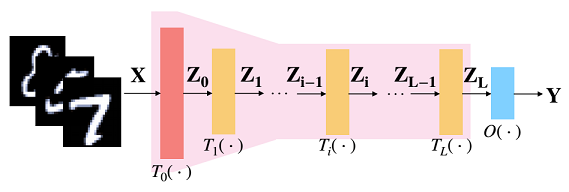\
Network with the selected architecture for training with HSIC-based IB loss [1].

The model includes $L$ number of layers with input $\textbf{X}\in\mathbb{R}^{m\times d_x}$ and output $\textbf{Y}\in\mathbb{R}^{m\times d_y}$.
Each layer performs a mapping on its input and results in an output $\textbf{Z}_l=T_l(\textbf{Z}_{l-1})$.\
\
Each dense layer is followed by a batch-normalization layer and a Relu activation layer. Finally, a Softmax layer with the number of neurons equal to the number of classes is the output layer.

In [7]:
def create_model(n_hidden_layer, n_neurons,input_size = 28*28):
 
  model = keras.Sequential()
  model.add(keras.layers.Input(shape=(input_size,)))

  for ii in range(n_hidden_layer):
      model.add(keras.layers.Dense(n_neurons))
      model.add(keras.layers.BatchNormalization())
      model.add(keras.layers.Activation(keras.activations.relu))

  model.add(keras.layers.Dense(10,activation='softmax'))


  return model

In [8]:
# create the model and show the summary of model
n_hidden_layer = 4
n_neurons = 256

model = create_model(n_hidden_layer = n_hidden_layer, n_neurons = n_neurons)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               200960    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 256)               0

# **Forward Layer-by-layer Training Algorithm with HSIC-based IB Loss**

The main part of [1] is the following proposed algorithm for training the network in a forward flow without error backpropagation.

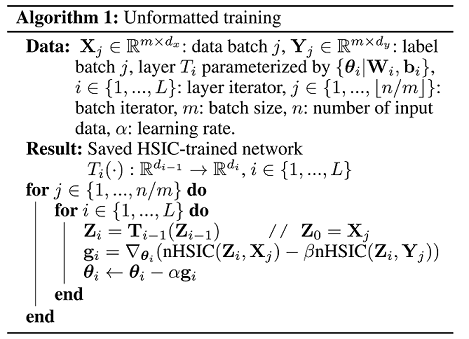

The algorithm loops through the epochs, and for each epoch loop, it finds the output of each layer from the output of the previous layer $\textbf{Z}_i=T_i(\textbf{Z}_{i-1})$. Then, the normalized HSIC-based IB is found for that output of layer $\textbf{Z}_i$, input batch of the network $\textbf{X}_j$, and output batch of the network $\textbf{Y}_j$
$$L(\theta_i)=\mathrm{nHSIC}(\textbf{Z}_i(\theta_i),\textbf{X}_j)-\beta\mathrm{nHSIC}(\textbf{Z}_i(\theta_i),\textbf{Y}_j).$$
\
Next, by finding the gradients of loss function $\nabla_{\theta_i}(L(\theta_i))$, parameters of each layer including weights of connections and biases  without finding the output of the network can be updated by gradient descent. It is obvious that the proposed algorithm works without any error backpropagation.


# **Initialization of Algorithm**

In [12]:
beta = 5000

epochs = 5;

len_test = 500;

batch_size = 512

Num_samples  = x_train.shape[0]

if Num_samples % batch_size == 0:

    Num_batches = int(Num_samples/batch_size)

else:

    Num_batches = int(Num_samples/batch_size)+1

#opt = tf.keras.optimizers.legacy.SGD(learning_rate=0.5)
opt = tf.keras.optimizers.legacy.Adam()

spaces = ' '*20

In [13]:
def show_statistics(epoch, loss, Hx, Hy):
  print('\n**************************************************'
        '\nEpoch:', epoch,
        '\nLoss IB:', loss_amnt ,
        '\nnHSIC(X,Z):', HSIC_x_z,
        '\nnHSIC(Y,Z):', HSIC_y_z,
        '\n**************************************************')

# **Body of Algorithm**

In [ ]:
# initialize validation data
input_test = x_test_norm[0:len_test]
label_test = y_test[0:len_test]
pred_test = model(input_test)

# find initial statistics
loss_amnt = HSIC_loss_norm(input_test, label_test, pred_test, beta).numpy()
HSIC_x_z = cal_HSIC(input_test, pred_test).numpy()
HSIC_y_z = cal_HSIC(label_test, pred_test).numpy()

# create a list of statistics
loss_amnt_vec = [loss_amnt]
HSIC_x_z_vec = [HSIC_x_z]
HSIC_y_z_vec = [HSIC_y_z]

show_statistics(0, loss_amnt, HSIC_x_z, HSIC_y_z)

# loop for number of epochs
for epoch in range(epochs):

  # shuffle input batches
  batch_indx = list(range(Num_batches))
  random.shuffle(batch_indx)

  cc = 0

  # loop for number of batches
  for ii in batch_indx:

    cc += 1
    
    # divide data to batches
    start_point = ii*batch_size
    end_point = min(Num_samples, (ii+1)*batch_size)
    net_input = x_train_norm[start_point:end_point,:]
    net_output = y_train[start_point:end_point,:]

    # assign input to layer Z0
    layer_input = net_input

    for layer in model.layers:       
        
        with tf.GradientTape() as tape:
       
          # make a prediction using the model and then calculate the loss with L1 norm regularization 
          layer_output = layer(layer_input,training=True)
          loss = HSIC_loss_norm(net_input, net_output, layer_output, beta) + tf.cast(tf.norm(model(net_input), ord=1), tf.float64)
          
        # calculate the gradients using tape and then update the
        grads = tape.gradient(loss, layer.trainable_weights)
        opt.apply_gradients(zip(grads, layer.trainable_weights))
        
        # assign output of the previous layer as input of the next layer
        layer_input = layer_output
        
    # calculate loss of each batch and show it
    batch_loss = HSIC_loss_norm(input_test, label_test, model(input_test), beta).numpy()
    print('\r(',cc,'/',Num_batches,')', 'Validation Loss:', batch_loss, spaces, end="")


  # calculate statistics of each epoch
  pred_test = model(input_test )
  loss_amnt = HSIC_loss_norm(input_test,label_test, pred_test,beta).numpy()
  HSIC_x_z = cal_HSIC(input_test, pred_test).numpy()
  HSIC_y_z = cal_HSIC(label_test, pred_test).numpy()
  
  show_statistics(epoch+1, loss_amnt, HSIC_x_z,HSIC_y_z)

  # update list of statistics
  loss_amnt_vec.append(loss_amnt)
  HSIC_x_z_vec.append(HSIC_x_z)
  HSIC_y_z_vec.append(HSIC_y_z)


# **Saving Weights of Model**

In [ ]:
Weights = model.get_weights()
np.save('Weights', Weights)

# **Plot of HSIC and Loss**

Here, statistics such as HSIC and loss for each epoch are plotted.

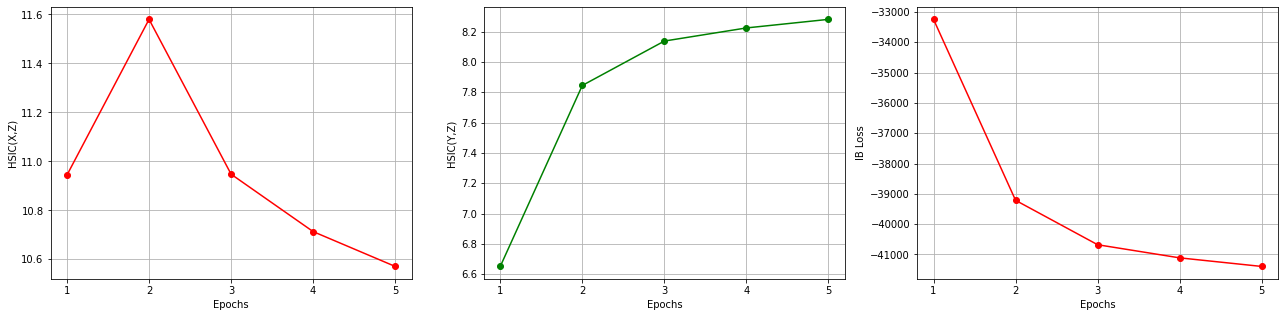

In [53]:
# create epoch vectors and plot vector of statistics
epochs_vec= np.arange(1,6)

fig, axs = plt.subplots(1,3, figsize=(22, 5), facecolor='w', edgecolor='k')
plt.setp(axs, xticks=list(range(6)), xticklabels=list(range(6)))

axs[0].plot(epochs_vec, HSIC_x_z_vec[1:],'-or')
axs[0].set_ylabel('HSIC(X,Z)')
axs[0].set_xlabel('Epochs')
axs[0].grid(True)

axs[1].plot(epochs_vec, HSIC_y_z_vec[1:],'-og')
axs[1].set_ylabel('HSIC(Y,Z)')
axs[1].set_xlabel('Epochs')
axs[1].grid(True)

axs[2].plot(epochs_vec, loss_amnt_vec[1:], '-or')
axs[2].set_ylabel('IB Loss')
axs[2].set_xlabel('Epochs')
axs[2].grid(True)


# **Finding the Related Permutation**

Since the loss function is not sensitive to the similarity of the position of its output to the true label, it is needed to find manually the permutation of the output of the network for finding the accuracy.

In [16]:
# return one-hot matrix for the output of the softmax layer
def find_permut(x):

  y = np.zeros(x.shape)

  for ii in range(x.shape[0]):

    y[ii,:] = np.where(x[ii,:]<np.max(x[ii,:]), 0, 1)

  dumy = np.sum(y, axis=0)

  return dumy.argmax()

In [17]:
# find the corresponding permutation for each class
def cores_class(y_train_sorted, x_train_sorted, model):
    # input y and x must be sorted based on true labels

    new_labels = []
    change_p = [0]

    # find the points that labels are changed in sorted arrays
    for ii in range(y_train_sorted.shape[0]-1):
      
      if y_train_sorted [ii+1]!=y_train_sorted [ii]:
        change_p.append(ii+1)

    change_p.append(y_train_sorted.shape[0])

    # find the permutation related for each class
    for jj in range(len(change_p)-1):

      input = x_train_sorted[change_p[jj]:change_p[jj+1],:]
      new_label = find_permut(model(input))
      new_labels.append(new_label)

    return new_labels

In [18]:
# print the distribution of output of the trained network for validation data
out_test = model(x_test_norm)
pred_test = np.zeros(out_test.shape)

for ii in range(out_test.shape[0]):
  pred_test[ii,:] = np.where(out_test[ii,:]<np.max(out_test[ii,:]), 0, 1)

print('distribution of output:',np.sum(pred_test, axis=0))

Distribution of outpput: [1016. 1042.  992.  969.  872.  978. 1010. 1044. 1150.  927.]


In [24]:
# print permutation of each class
indx_class = cores_class(y_train_sorted, x_train_sorted, model)

print('class label:     ', list(range(10)),
   '\nclass permutaion:', indx_class)

class label:      [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
class permutaion: [6, 8, 1, 0, 2, 4, 5, 7, 9, 3]


# **The Output of Network and Its Accuracy**

In [22]:
# find changing point of lables in sorted validation data
cp = [0]
for ii in range(y_test_sorted.shape[0]-1):
 
  if y_test_sorted [ii+1]!=y_test_sorted [ii]:
    cp.append(ii+1)

cp.append(y_test_sorted.shape[0])


*************************** 
Final Accuracy is: 0.9503 
***************************


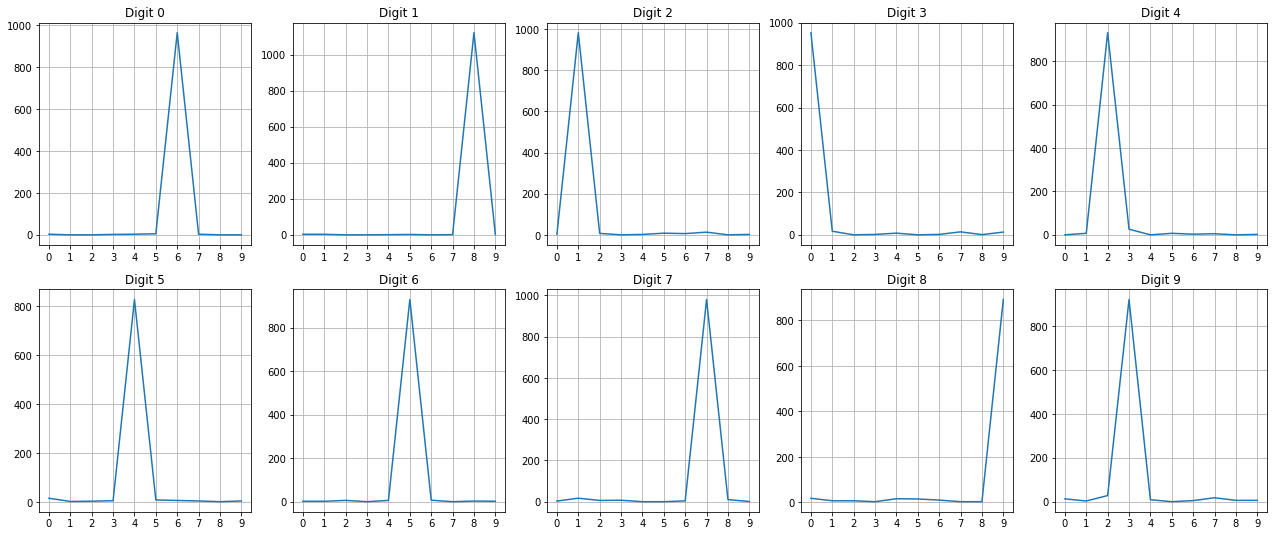

In [25]:
# show the output and the accuracy of the network for validation data
accuracy = []
pred2 = np.zeros(x_test.shape)
num_corrects = 0

fig, axs = plt.subplots(2, 5, figsize=(22, 9), facecolor='w', edgecolor='k')
plt.setp(axs, xticks=list(range(10)), xticklabels=list(range(10)))

for ii in range(len(cp)-1):

  cls_input = x_test_sorted[cp[ii]:cp[ii+1]]

  pred = model.predict(cls_input, verbose=0)
  pred2 = np.zeros(pred.shape)

  for jj in range(pred.shape[0]):

    pred2[jj,:] = np.where(pred[jj]<np.max(pred[jj]), 0, 1)

  corrects=np.sum(pred2[:,indx_class[ii]], axis=0)
  num_corrects = num_corrects + np.sum(pred2[:, indx_class[ii]], axis=0)
  
  axs[ii//5, ii%5].plot(np.sum(pred2, axis = 0))
  axs[ii//5, ii%5].set_title("Digit "+str(ii))
  axs[ii//5, ii%5].grid(True)
    
acc_t = num_corrects/x_test_sorted.shape[0]

print('\n***************************',
      '\nFinal Accuracy is:', acc_t,
      '\n***************************')

# **Formatted Network**

In some cases, the output of the network is not unique, and two neurons might fire for one class, or it is desirable to let the new layer and a learning process learn the permutation. 

In these cases, another layer of Softmax can be added to form a formatted network. Then, all the previous weights are frozen, and using cross-entropy loss function and gradient descent, the appropriate permutation can be learned without backpropagation for the formatted network.

In [26]:
# create a formatted model from the previous model
Weights_model  = model.get_weights()

formatted_model = create_model(n_hidden_layer = n_hidden_layer, n_neurons = n_neurons)

formatted_model.set_weights(Weights_model ) 

# freeze all the weights of network to stop error back propagation
for ii in formatted_model.layers:
  ii.trainable = False

# add a softmax layer to the freezed model to create formatted model
formatted_model.add(keras.layers.Dense(10, activation='softmax'),)


In [27]:
# compile the formatted model with cross-entropy loss
formatted_model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

# learn the permutation with a gradient-descent-based optimization
history = formatted_model.fit(x_train_norm, y_train, batch_size=128, epochs=3, verbose=True)

print('\n****************************************\n',
      '\nValidation Accuracy For Formatted Model:')
loss, accuracy  = formatted_model.evaluate(x_test_norm, y_test, verbose=True)

Epoch 1/3
469/469 [==============================] - 4s 5ms/step - loss: 2.0164 - accuracy: 0.4430
Epoch 2/3
469/469 [==============================] - 2s 3ms/step - loss: 1.4058 - accuracy: 0.9287
Epoch 3/3
469/469 [==============================] - 2s 3ms/step - loss: 0.9593 - accuracy: 0.9511

****************************************
 
Validation Accuracy For Formatted Model:
313/313 [==============================] - 1s 3ms/step - loss: 0.7900 - accuracy: 0.9496


# References

[1] Ma, Wan-Duo Kurt, J. P. Lewis, and W. Bastiaan Kleijn. "The HSIC bottleneck: Deep learning without back-propagation." In Proceedings of the AAAI Conference on Artificial Intelligence, vol. 34, no. 04, pp. 5085-5092. 2020.

[2] Tishby, Naftali, and Noga Zaslavsky. "Deep learning and the information bottleneck principle." In 2015 IEEE Information Theory Workshop (ITW), pp. 1-5. 2015.

[3] Shwartz-Ziv, Ravid, and Naftali Tishby. "Opening the black box of deep neural networks via information." arXiv preprint arXiv:1703.00810 (2017).